In [5]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2' #um Warnmeldung loszuwerden

import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
np.set_printoptions(precision=3, suppress=True) #numpy outputs einfacher zu lesen

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

### 1. Data Generation

In [4]:
# https://archive.ics.uci.edu/ml/datasets/Auto+MPG
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(url, names=column_names, na_values='?',
                      comment='\t', sep=' ', skipinitialspace=True)
                      

In [7]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


#### Data Cleaning

In [11]:
dataset = dataset.dropna()

origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1) * 1
dataset['Europe'] = (origin == 2) * 1
dataset['Japan'] = (origin == 3) * 1

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,0,0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,0,0


### 2. Data Preparation

In [12]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

print(dataset.shape, train_dataset.shape, test_dataset.shape)
train_dataset.describe().transpose()

(392, 10) (314, 10) (78, 10)


,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [13]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [45]:
def plot(feature, x = None, y = None):
    plt.figure(figsize=(10,8))
    plt.scatter(train_features[feature], train_labels, label='Data')
    if x is not None and y is not None:
        plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel(feature)
    plt.ylabel('MPG')
    plt.legend()

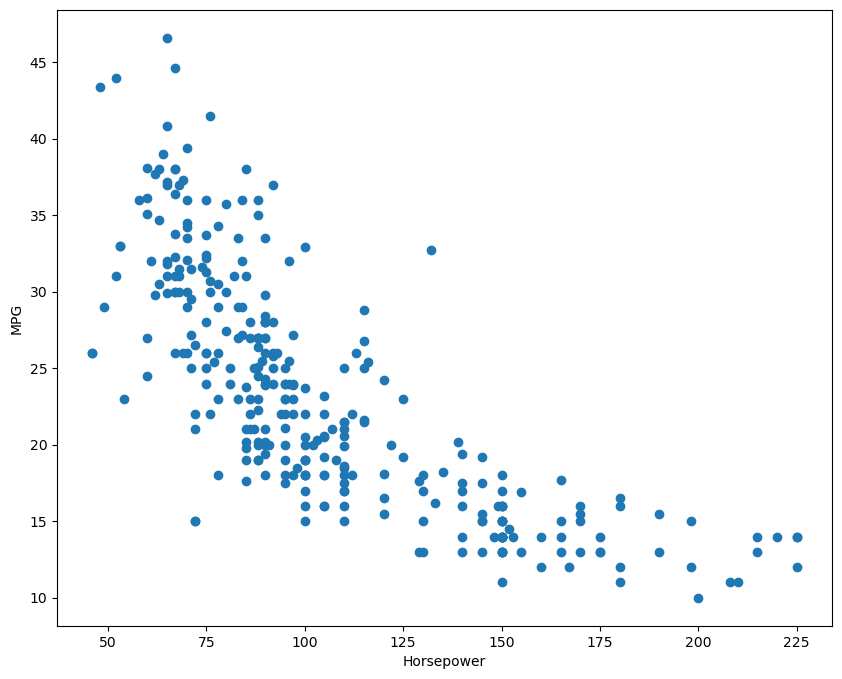

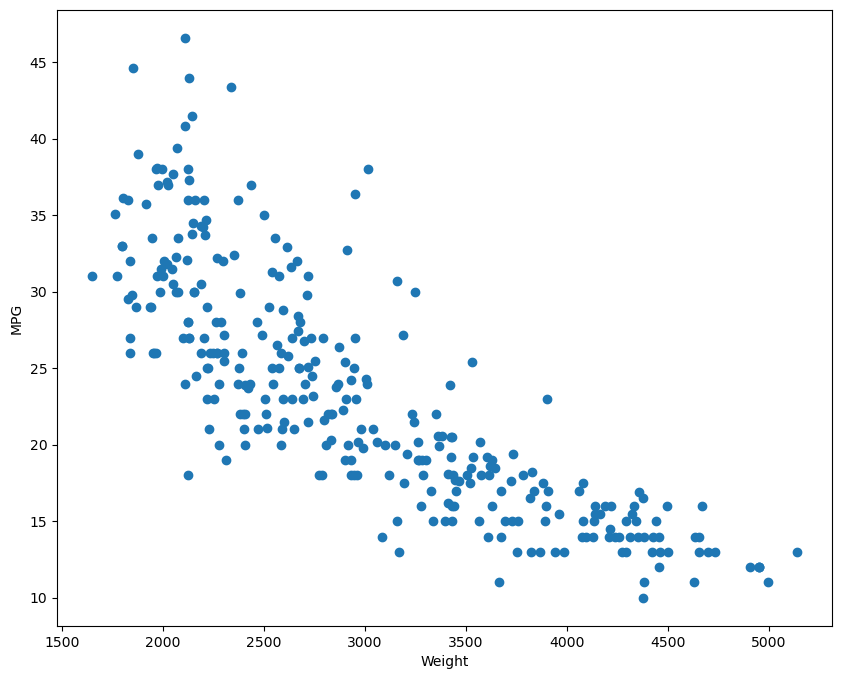

In [19]:
plot('Horsepower')
plot('Weight')

In [20]:
print(train_dataset.describe().transpose()[['mean', 'std']])

                     mean         std
MPG             23.310510    7.728652
Cylinders        5.477707    1.699788
Displacement   195.318471  104.331589
Horsepower     104.869427   38.096214
Weight        2990.251592  843.898596
Acceleration    15.559236    2.789230
Model Year      75.898089    3.675642
USA              0.624204    0.485101
Europe           0.178344    0.383413
Japan            0.197452    0.398712


Die Daten haben eine unterschiedliche Rannge, weshalb eine Normaliserung Sinn macht

In [21]:
#Normalizte
normalizer = preprocessing.Normalization()
#adapt to the data
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.624    0.178
     0.197]]


Wenn der normalizer jetzt aufgerufen wird, returned er die Input-Daten bei welchen jedes Feature individuell normalisiert wurde:
(Input - Mean) / Std

In [22]:
# beispiel
first = np.array(train_features[:1])
print('First Example: ', first)
print('Normalized: ', normalizer(first).numpy())

First Example:  [[   4.    90.    75.  2125.    14.5   74.     1.     0.     0. ]]
Normalized:  [[-0.871 -1.011 -0.785 -1.027 -0.38  -0.517  0.776 -0.466 -0.496]]


In [26]:

 # 1. Normalize the input horsepower
 # 2. Apply a linear transformation (y = m*x+b) to produce 1 output using layers.Dense

feature = 'Horsepower'
single_feature = np.array(train_features[feature])
print(single_feature.shape, train_features.shape)

# Normalization
single_feature_normalizer = layers.Normalization(input_shape=[1,], axis=None)

# adapt to the data
single_feature_normalizer.adapt(single_feature)


(314,) (314, 9)


### 3. Modeling (Linear Regression & DNN)

#### 3.1 LineareRegression für nur ein Feature

In [32]:
single_feature_model = keras.models.Sequential([
    single_feature_normalizer,
    layers.Dense(units=1) #Linear Model
])

In [33]:
single_feature_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [34]:
# loss and optimizer
loss = keras.losses.MeanAbsoluteError()
optim = keras.optimizers.Adam(learning_rate=0.1)

single_feature_model.compile(optimizer=optim, loss=loss)

In [35]:
history = single_feature_model.fit(
    train_features[feature], train_labels,
    epochs = 100,
    verbose = 1,
    validation_split = 0.2
)

Epoch 1/100
8/8 [==============================] - 1s 26ms/step - loss: 22.8644 - val_loss: 22.9304
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 22.0666 - val_loss: 22.1307
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 21.2639 - val_loss: 21.3304
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 20.4660 - val_loss: 20.5306
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 19.6627 - val_loss: 19.7305
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 18.8629 - val_loss: 18.9305
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 18.0632 - val_loss: 18.1305
Epoch 8/100
8/8 [==============================] - 0s 8ms/step - loss: 17.2632 - val_loss: 17.3305
Epoch 9/100
8/8 [==============================] - 0s 9ms/step - loss: 16.4627 - val_loss: 16.5305
Epoch 10/100
8/8 [==============================] - 0s 9ms/step - loss: 15.6623 - val_loss: 15.7305
Epoch 11

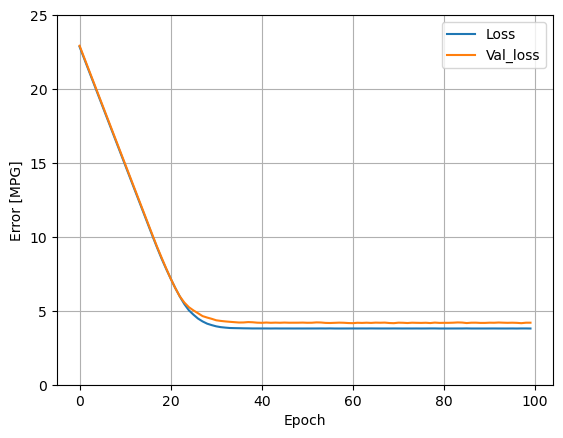

In [36]:
def plot_loss(history):
    plt.plot(history.history['loss'], label ='Loss')
    plt.plot(history.history['val_loss'], label = 'Val_loss')
    plt.ylim([0, 25])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)


plot_loss(history)

In [37]:
# evaluation
single_feature_model.evaluate(
    test_features[feature],
    test_labels, verbose=1
)

3/3 [==============================] - 0s 5ms/step - loss: 3.6591


3.659050941467285

7/7 [==============================] - 0s 3ms/step


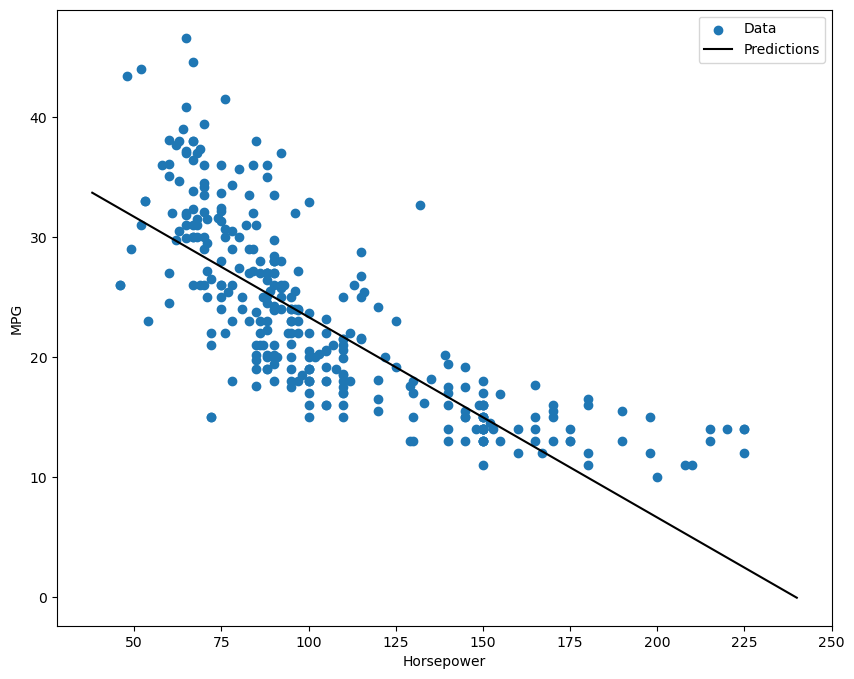

In [46]:
#predictions
range_min = np.min(test_features[feature]) - 10
range_max = np.max(test_features[feature]) + 10
x = tf.linspace(range_min, range_max, 200)
y = single_feature_model.predict(x)

plot(feature, x, y)

#### 3.2 Deep neural network (DNN) für ein Feature

In [40]:
dnn_model = keras.Sequential([
    single_feature_normalizer,
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

In [41]:
dnn_model.compile(loss = loss, optimizer=keras.optimizers.Adam(learning_rate=0.001))

dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [42]:
dnn_model.fit(
    train_features[feature], train_labels,
    validation_split=0.2, verbose=1, epochs=100
)

Epoch 1/100
8/8 [==============================] - 1s 39ms/step - loss: 23.1763 - val_loss: 23.5572
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 22.9398 - val_loss: 23.3073
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 22.6865 - val_loss: 23.0012
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 22.3555 - val_loss: 22.6017
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 21.9350 - val_loss: 22.0937
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 21.4022 - val_loss: 21.4511
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 20.7176 - val_loss: 20.6318
Epoch 8/100
8/8 [==============================] - 0s 8ms/step - loss: 19.8592 - val_loss: 19.5903
Epoch 9/100
8/8 [==============================] - 0s 8ms/step - loss: 18.7562 - val_loss: 18.2918
Epoch 10/100
8/8 [==============================] - 0s 8ms/step - loss: 17.4091 - val_loss: 16.7855
Epoch 1

In [43]:
#evaluation
dnn_model.evaluate(test_features[feature], test_labels, verbose=1)

3/3 [==============================] - 0s 4ms/step - loss: 2.9095


2.9095215797424316

7/7 [==============================] - 0s 1ms/step


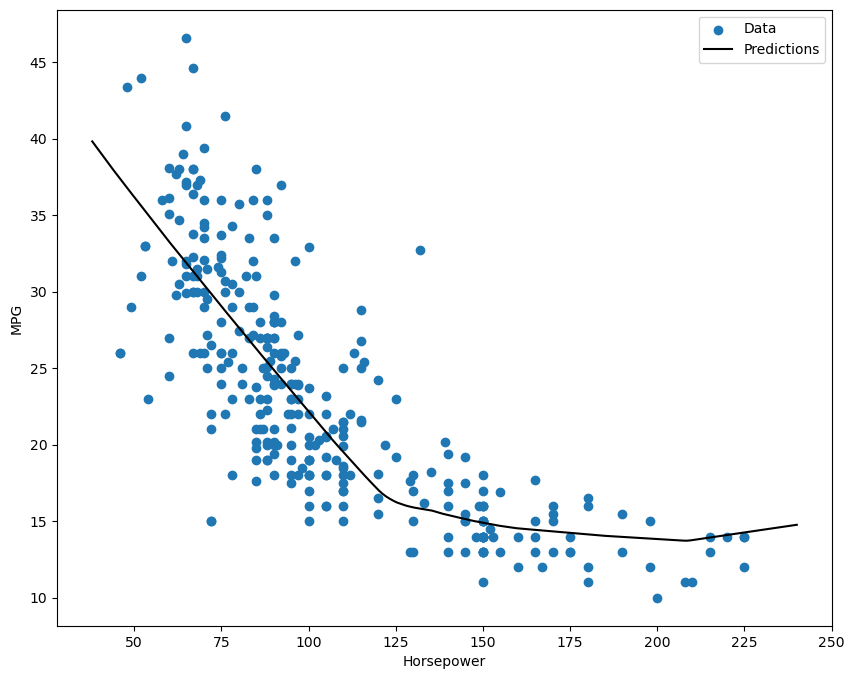

In [47]:
x = tf.linspace(range_min, range_max, 200)
y = dnn_model.predict(x)

plot(feature, x, y)

#### 3.3 Lineare Regression mit allen Features

In [48]:
linear_model = keras.models.Sequential([
    normalizer,
    keras.layers.Dense(units=1)
])

linear_model.compile(loss=loss, optimizer=tf.optimizers.Adam(learning_rate=0.1))

In [49]:
linear_model.fit(train_features, train_labels, epochs=100, verbose=1, validation_split=0.2)

Epoch 1/100
8/8 [==============================] - 1s 22ms/step - loss: 22.9451 - val_loss: 22.8604
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 22.0926 - val_loss: 22.1236
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 21.2918 - val_loss: 21.4330
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 20.4366 - val_loss: 20.6980
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 19.6312 - val_loss: 19.9615
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 18.8143 - val_loss: 19.2452
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 17.9826 - val_loss: 18.5121
Epoch 8/100
8/8 [==============================] - 0s 8ms/step - loss: 17.1725 - val_loss: 17.7903
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 16.3541 - val_loss: 17.0604
Epoch 10/100
8/8 [==============================] - 0s 7ms/step - loss: 15.5314 - val_loss: 16.3423
Epoch 11

In [50]:
linear_model.evaluate(test_features, test_labels, verbose=1)

3/3 [==============================] - 0s 3ms/step - loss: 2.4932


2.4931745529174805

#### 3.4 DNN mit allen Features

In [56]:
dnn_2_model = keras.Sequential([
    normalizer,
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

dnn_2_model.compile(loss = loss, optimizer=keras.optimizers.Adam(learning_rate=0.001))

dnn_2_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_9 (Dense)             (None, 64)                640       
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [57]:
dnn_2_model.fit(train_features, train_labels, epochs=100, validation_split=0.2)

Epoch 1/100
8/8 [==============================] - 1s 22ms/step - loss: 23.0920 - val_loss: 23.1952
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 22.4482 - val_loss: 22.4744
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 21.7306 - val_loss: 21.6397
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 20.8787 - val_loss: 20.5940
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 19.7735 - val_loss: 19.1931
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 18.2806 - val_loss: 17.2868
Epoch 7/100
8/8 [==============================] - 0s 7ms/step - loss: 16.3105 - val_loss: 15.1037
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 14.1875 - val_loss: 12.9887
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 11.8553 - val_loss: 10.7170
Epoch 10/100
8/8 [==============================] - 0s 7ms/step - loss: 9.4498 - val_loss: 8.0376
Epoch 11/1

In [58]:
dnn_2_model.evaluate(test_features, test_labels, verbose=1)

3/3 [==============================] - 0s 4ms/step - loss: 1.7237


1.7237316370010376